# Recurrent Neural Networks (RNN) with Keras

Good for modeling sequence data such as time series or natural language.

## Setup

In [4]:
!pip install -q -U tensorflow
!pip install -q tensorflow_datasets

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
model = keras.models.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model.add(layers.LSTM(128))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


In [9]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteDY8F50/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteDY8F50/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteDY8F50/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [12]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [14]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [16]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy()[:3])
    print('label: ', label.numpy()[:3])

text:  [b"I went to this movie expecting a concise movie relating the effect the Son of Sam had on the society. I didn't expect Spike Lee to force-feed me more garbage on racial tension, mob-justice, or the inability of the common citizen to make a choice under pressure by peers. Lee has presented an extreme opinion.<br /><br />The entire movie could have been more effective if in a 90-min format with more focus, less tangential sub-plots.<br /><br />Don't even bother renting the video unless you passionately enjoy Spike Lee; in such a case, the theatre is worth it. This is not an escapist movie."
 b"After reading the book, I loved the story. Watching the movie I was disappointed that so many changes were made. It is understandable that books and movies differ but it was two different stories, only the names and some of the book's story remained. Read the book and you'll have a better understanding of the movie. The book gives you a better development of the characters. These character

In [17]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [18]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [20]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 418,   6, ...,   0,   0,   0],
       [101, 877,   2, ...,   0,   0,   0],
       [  1, 173,  36, ...,   0,   0,   0]])

In [22]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I went to this movie expecting a concise movie relating the effect the Son of Sam had on the society. I didn't expect Spike Lee to force-feed me more garbage on racial tension, mob-justice, or the inability of the common citizen to make a choice under pressure by peers. Lee has presented an extreme opinion.<br /><br />The entire movie could have been more effective if in a 90-min format with more focus, less tangential sub-plots.<br /><br />Don't even bother renting the video unless you passionately enjoy Spike Lee; in such a case, the theatre is worth it. This is not an escapist movie."
Round-trip:  i went to this movie expecting a [UNK] movie [UNK] the effect the son of [UNK] had on the society i didnt expect [UNK] lee to [UNK] me more [UNK] on [UNK] [UNK] [UNK] or the [UNK] of the [UNK] [UNK] to make a [UNK] under [UNK] by [UNK] lee has [UNK] an [UNK] [UNK] br the entire movie could have been more [UNK] if in a [UNK] [UNK] with more [UNK] less [UNK] [UNK] br dont even [

The model diagram:
- Model Sequential
- encoder converts text to sequence of token indices
- Embedding layer: An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors.

In [27]:
model = keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [28]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [29]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00417742]


In [30]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00417742]


In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [32]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 41s 90ms/step - loss: 0.6767 - accuracy: 0.5187 - val_loss: 0.4516 - val_accuracy: 0.7620
Epoch 2/10
391/391 [==============================] - 34s 85ms/step - loss: 0.3920 - accuracy: 0.8223 - val_loss: 0.3644 - val_accuracy: 0.8198
Epoch 3/10
391/391 [==============================] - 34s 85ms/step - loss: 0.3392 - accuracy: 0.8492 - val_loss: 0.3329 - val_accuracy: 0.8536
Epoch 4/10
391/391 [==============================] - 34s 85ms/step - loss: 0.3183 - accuracy: 0.8625 - val_loss: 0.3301 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 34s 85ms/step - loss: 0.3093 - accuracy: 0.8659 - val_loss: 0.3467 - val_accuracy: 0.8307
Epoch 6/10
391/391 [==============================] - 34s 85ms/step - loss: 0.3070 - accuracy: 0.8676 - val_loss: 0.3262 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 34s 85ms/step - loss: 0.2994 - accuracy: 0.8702 - val_loss: 0.3229 - val_accuracy:

In [33]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 15s 39ms/step - loss: 0.3259 - accuracy: 0.8440
Test Loss: 0.3259401023387909
Test Accuracy: 0.8440399765968323


(0.0, 0.6344209358096122)

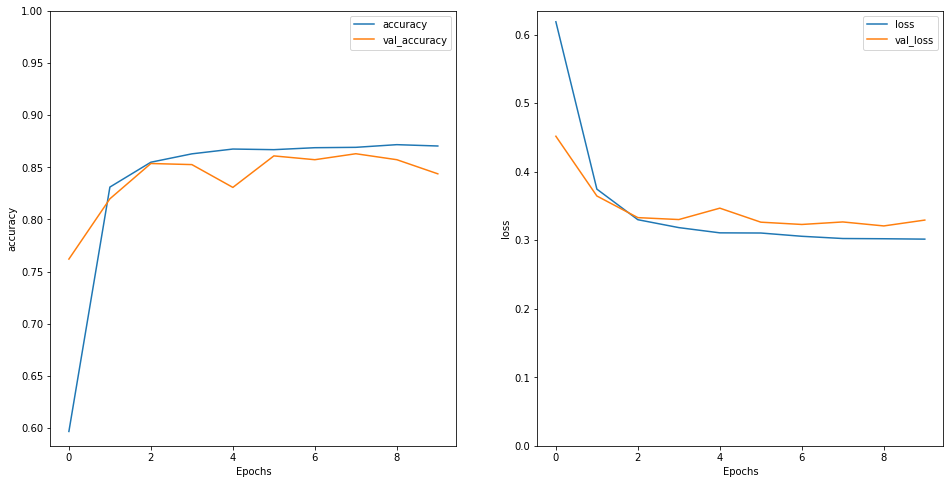

In [34]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [35]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))